Sensitivity:  4.227928156417236
Gradient Descend converged at 500 steps and cost: 1.14910935080018e-06
Mean Square Error:  0.00037530406543518946
Signal to Noise Ratio:  30.616772246017373  dB


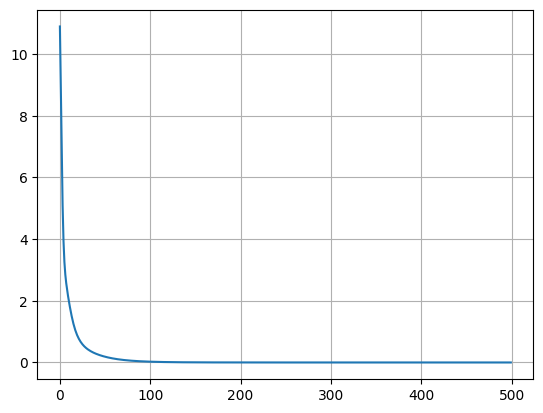

In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA


n = 3
dev = qml.device('default.qubit', wires=n)
L =2
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
   
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
#Circuit requires 2n+4nL params or 2n(1+2L) params
init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

N = 2**n

A = Generate_Hermitian(N,ver=2,eig_min=1,eig_max=5)
w, v = LA.eig(A)
sens = np.max(w)/np.min(w)
#print("Eigen Values are: ",w)
#print("Eiegen Vectors:")
#print(v)
print("Sensitivity: ",sens)

#A  = np.array([[3,0,0,0],[0,5,0,0],[0,0,9,0],[0,0,0,2]])
y = np.random.rand(N,1)
y = y/LA.norm(y)
#y = 0.5*np.array([[1],[0],[0],[0]])
A_inv = LA.inv(A)
x = np.matmul(A_inv,y)

Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
Hd = np.matmul(Hd,A)
Hd =0.5*( Hd+Hd.T.conj())

obs = qml.Hermitian(Hd, wires=range(n))
H = qml.Hamiltonian((0.5,),(obs,))
step_size = 0.03
max_iter = 500
conv_tol = 1e-6
opt = qml.GradientDescentOptimizer(step_size)
new_params = init_params
cost_arr = []



for j in range(max_iter):

    new_params =  opt.step(VQC, new_params[0],n,L)
    #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
    
    new_cost =VQC(new_params[0],n,L)
    cost_arr.append(new_cost)
    #x.append(y_out[i])
    #y_out.append(serial_quantum_model(weights, x[i+1]))
    if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
        break



print("Gradient Descend converged at {0} steps and cost: {1}".format(j+1,new_cost))  

plt.plot(cost_arr)
plt.grid()
# Ax=y -> v s.t. |v| = 1 and x = z*v, A*v = w, z*w = y, z = <y/w> , x = <y/w>*v


v = Res(new_params[0], n,L)
w = np.matmul(A,np.array([v]).T)
z = np.mean(np.divide(y,w))
x_est = z*v
error = x_est-x.T
mse = LA.norm(error)
SNR = 10*np.log10(LA.norm(x)/mse)

#print("True x: ",x.T)
#print("Estimated x: ",x_est)
#print("Error: ",error)
print("Mean Square Error: ",mse)
print("Signal to Noise Ratio: ",SNR," dB")

#print(np.divide(v,x.T))
#print(np.divide(w,y))

#print(qml.draw(VQC)(new_params[0], n,L))


In [2]:
### Convergence Speed

Eigen Values are:  [3.74  1.615 1.436 1.403]
Eiegen Vectors:
[[ 0.388 -0.606  0.565  0.405]
 [-0.697 -0.61  -0.32   0.201]
 [-0.413  0.508  0.351  0.669]
 [ 0.439  0.046 -0.676  0.59 ]]
Sensitivity:  2.6665314502141935
Gradient Descend converged at 1000 steps and cost: 2.754031773053609e-16


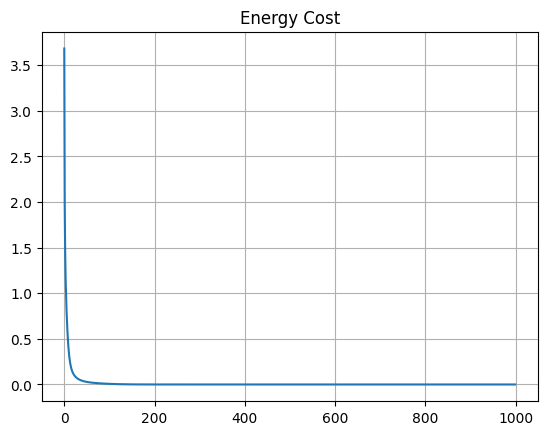

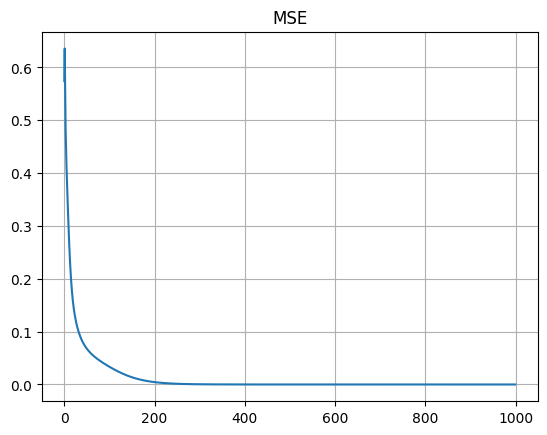

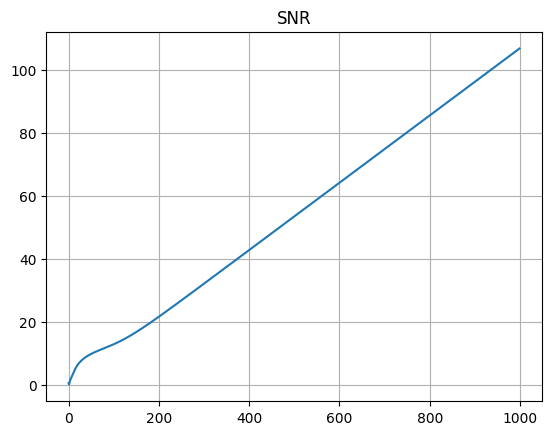

True x:  [[0.346 0.383 0.242 0.301]]
Final Estimated x:  [0.346+3.957e-12j 0.383+6.704e-12j 0.242-9.369e-12j 0.301+9.443e-13j]
Final Error:  [[-3.314e-12+3.957e-12j -2.861e-12+6.704e-12j  3.107e-12-9.369e-12j
   1.418e-12+9.443e-13j]]
Final Mean Square Error:  1.3420278555877805e-11
Final Signal to Noise Ratio:  106.81742147946034  dB


In [8]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA


n = 2
dev = qml.device('default.qubit', wires=n)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
#Circuit requires 2n+4nL params or 2n(1+2L) params
init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

N = 2**n

A = Generate_Hermitian(N,ver=2,eig_min=1,eig_max=7)
w, v = LA.eig(A)
sens = np.max(w)/np.min(w)
print("Eigen Values are: ",w)
print("Eiegen Vectors:")
print(v)
print("Sensitivity: ",sens)

#A  = np.array([[3,0,0,0],[0,5,0,0],[0,0,9,0],[0,0,0,2]])
y = np.random.rand(N,1)
y = y/LA.norm(y)
#y = 0.5*np.array([[1],[0],[0],[0]])
A_inv = LA.inv(A)
x = np.matmul(A_inv,y)

Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
Hd = np.matmul(Hd,A)
Hd =0.5*( Hd+Hd.T.conj())

obs = qml.Hermitian(Hd, wires=range(n))
H = qml.Hamiltonian((0.5,),(obs,))
step_size = 0.1
max_iter = 1000
conv_tol = 1e-20
opt = qml.GradientDescentOptimizer(step_size)
new_params = init_params
cost_arr = []
mse_arr = []
snr_arr = []


for j in range(max_iter):

    new_params =  opt.step(VQC, new_params[0],n,L)
    #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
    
    new_cost =VQC(new_params[0],n,L)
    v = Res(new_params[0], n,L)
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x.T
    mse = LA.norm(error)
    SNR = 10*np.log10(LA.norm(x)/mse)
    
    mse_arr.append(mse)
    snr_arr.append(SNR)
    cost_arr.append(new_cost)
    #x.append(y_out[i])
    #y_out.append(serial_quantum_model(weights, x[i+1]))
    if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
        break



print("Gradient Descend converged at {0} steps and cost: {1}".format(j+1,new_cost))  

plt.figure(1)
plt.plot(cost_arr)
plt.title("Energy Cost")
plt.grid()
plt.show()

plt.figure(2)
plt.plot(mse_arr)
plt.title("MSE")
plt.grid()
plt.show()

plt.figure(3)
plt.plot(snr_arr)
plt.title("SNR")
plt.grid()
plt.show()
# Ax=y -> v s.t. |v| = 1 and x = z*v, A*v = w, z*w = y, z = <y/w> , x = <y/w>*v


v = Res(new_params[0], n,L)
w = np.matmul(A,np.array([v]).T)
z = np.mean(np.divide(y,w))
x_est = z*v
error = x_est-x.T
mse = LA.norm(error)
SNR = 10*np.log10(LA.norm(x)/mse)

print("True x: ",x.T)
print("Final Estimated x: ",x_est)
print("Final Error: ",error)
print("Final Mean Square Error: ",mse)
print("Final Signal to Noise Ratio: ",SNR," dB")

#print(np.divide(v,x.T))
#print(np.divide(w,y))

#print(qml.draw(VQC)(new_params[0], n,L))


### SNR and MSE Monte Carlo Simulation

In [53]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA


n = 2
dev = qml.device('default.qubit', wires=n)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L,obs):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L,obs)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
    
def Generate_A_y(n,L,eig_range):
    N = 2**n
    A = Generate_Hermitian(N,ver=2,eig_min=eig_range[0],eig_max=eig_range[1])
    y = np.random.rand(N,1)
    y = y/LA.norm(y)
    return A,y
    
    
def Invert_A(A,y,n,L,max_iter=500,step_size=0.03,conv_tol=10e-6):
    
    #Circuit requires 2n+4nL params or 2n(1+2L) params
    init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

    N = 2**n
    A_inv = LA.inv(A)
    x = np.matmul(A_inv,y)
    
    #prepare the Hamiltonian
    Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
    Hd = np.matmul(Hd,A)
    Hd =0.5*( Hd+Hd.T.conj())

    obs = qml.Hermitian(Hd, wires=range(n))
    #H = qml.Hamiltonian((0.5,),(obs,))
    opt = qml.GradientDescentOptimizer(step_size)
    new_params = init_params
    cost_arrr = []

    for j in range(max_iter):

        new_params =  opt.step(VQC, new_params[0],n,L,obs)
        #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
        new_cost = VQC(new_params[0],n,L,obs)
        cost_arr.append(new_cost)
        
        if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
            break



    v = Res(new_params[0], n,L)
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x.T
    mse = LA.norm(error)
    SNR = 10*np.log10(LA.norm(x)/mse)
    #u = np.matmul(Hd,np.array([v]).T)
 
    return new_cost,mse,SNR

eig_range = [1,5]
cost_arr = []
mse_arr = []
snr_arr = []
samples = 200
for k in range(samples):

    A,y = Generate_A_y(n,L,eig_range)
    cost,mse,SNR = Invert_A(A,y,n,L)
    cost_arr.append(cost)
    mse_arr.append(mse)
    snr_arr.append(SNR)
    if k%10 == 9:
        print("Iteration: {0} completed".format(k+1))

print(cost_arr)
print(mse_arr)
print(snr_arr)

Iteration: 10 completed
Iteration: 20 completed
Iteration: 30 completed
Iteration: 40 completed
Iteration: 50 completed
Iteration: 60 completed
Iteration: 70 completed
Iteration: 80 completed
Iteration: 90 completed
Iteration: 100 completed
Iteration: 110 completed
Iteration: 120 completed
Iteration: 130 completed
Iteration: 140 completed
Iteration: 150 completed
Iteration: 160 completed
Iteration: 170 completed
Iteration: 180 completed
Iteration: 190 completed
Iteration: 200 completed


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
cost_arr = np.array(cost_arr)
mse_arr = np.array(mse_arr)
snr_arr = np.array(snr_arr)
print(np.max(cost_arr))
print(np.max(mse_arr))
print(np.min(snr_arr))

67.64881770484041
0.7917368995248514
-4.569988503002323


## Plot

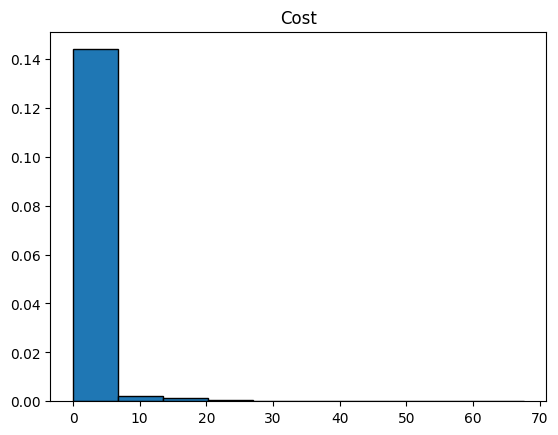

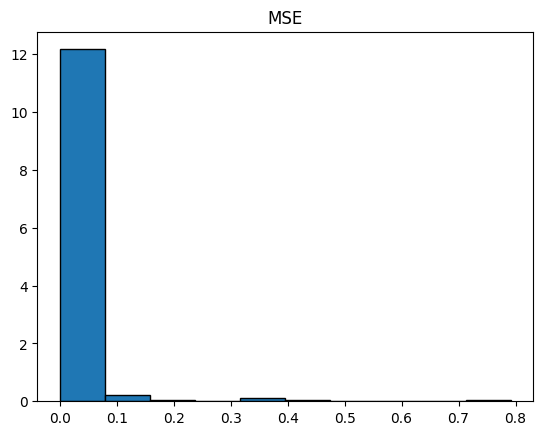

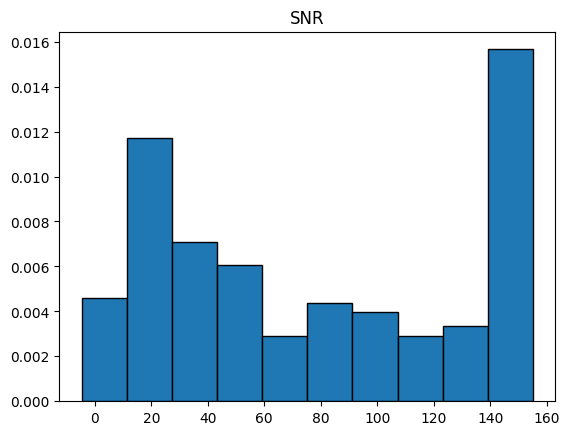

In [4]:
%matplotlib inline

plt.figure(1)
plt.title("Cost")
plt.hist(cost_arr,density=True,bins=10 , edgecolor='k', linewidth=1)
plt.show() 




plt.figure(2)
plt.title("MSE")
plt.hist(mse_arr,density=True,bins=10, edgecolor='k', linewidth=1)
plt.show() 

plt.figure(3)
plt.title("SNR")
plt.hist(snr_arr,density=True,bins=10, edgecolor='k', linewidth=1)
plt.show() 

2+4+8+16+32 = 62
1+2+4+8+32+64

In [5]:

mean_cost = np.mean(cost_arr)
std_cost = np.std(cost_arr)
mean_mse = np.mean(mse_arr)
std_mse = np.std(mse_arr)
mean_snr = np.mean(snr_arr)
std_snr = np.std(snr_arr)

print("Mean Cost: {0} and STD of Cost: {1}".format(mean_cost,std_cost))
print("Mean MSE: {0} and STD of MSE: {1}".format(mean_mse,std_mse))
print("Mean SNR: {0} and STD of SNR: {1}".format(mean_snr,std_snr))

Mean Cost: 0.5786166349217394 and STD of Cost: 2.5966523970343984
Mean MSE: 0.011924458866438958 and STD of MSE: 0.06478012936003204
Mean SNR: 76.85595493372644 and STD of SNR: 52.40644071326941


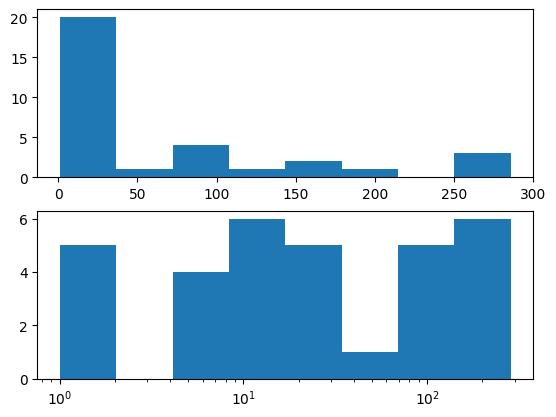

In [22]:

import numpy as np
import matplotlib.pyplot as plt

x = [2, 1, 76, 140, 286, 267, 60, 271, 5, 13, 9, 76, 77, 6, 2, 27, 22, 1, 12, 7, 
     19, 81, 11, 173, 13, 7, 16, 19, 23, 197, 167, 1]


# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=8)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

In [38]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA


n = 2
dev = qml.device('default.qubit', wires=n)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
#Circuit requires 2n+4nL params or 2n(1+2L) params
init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

N = 2**n

A = Generate_Hermitian(N,ver=2,eig_min=0.3,eig_max=5)
w, v = LA.eig(A)
sens = np.max(w)/np.min(w)
print("Eigen Values are: ",w)
print("Eiegen Vectors:")
print(v)
print("Sensitivity: ",sens)

#A  = np.array([[3,0,0,0],[0,5,0,0],[0,0,9,0],[0,0,0,2]])
y = np.random.rand(N,1)
y = y/LA.norm(y)
#y = 0.5*np.array([[1],[0],[0],[0]])
A_inv = LA.inv(A)
x = np.matmul(A_inv,y)

Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
Hd = np.matmul(Hd,A)
Hd =0.5*( Hd+Hd.T.conj())

obs = qml.Hermitian(Hd, wires=range(n))
H = qml.Hamiltonian((0.5,),(obs,))
step_size = 0.03
max_iter = 1000
conv_tol = 1e-6
opt = qml.GradientDescentOptimizer(step_size)
new_params = init_params
cost_arr = []
mse_arr = []
snr_arr = []


for j in range(max_iter):

    new_params =  opt.step(VQC, new_params[0],n,L)
    #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
    
    new_cost =VQC(new_params[0],n,L)
    v = Res(new_params[0], n,L)
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x.T
    mse = LA.norm(error)
    SNR = 10*np.log10(LA.norm(x)/mse)
    
    mse_arr.append(mse)
    snr_arr.append(SNR)
    cost_arr.append(new_cost)
    #x.append(y_out[i])
    #y_out.append(serial_quantum_model(weights, x[i+1]))
    if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
        break



print("Gradient Descend converged at {0} steps and cost: {1}".format(j+1,new_cost))  

plt.figure(1)
plt.plot(cost_arr)
plt.title("Energy Cost")
plt.grid()
plt.show()

plt.figure(2)
plt.plot(mse_arr)
plt.title("MSE")
plt.grid()
plt.show()

plt.figure(3)
plt.plot(snr_arr)
plt.title("SNR")
plt.grid()
plt.show()
# Ax=y -> v s.t. |v| = 1 and x = z*v, A*v = w, z*w = y, z = <y/w> , x = <y/w>*v


v = Res(new_params[0], n,L)
w = np.matmul(A,np.array([v]).T)
z = np.mean(np.divide(y,w))
x_est = z*v
error = x_est-x.T
mse = LA.norm(error)
SNR = 10*np.log10(LA.norm(x)/mse)

print("True x: ",x.T)
print("Final Estimated x: ",x_est)
print("Final Error: ",error)
print("Final Mean Square Error: ",mse)
print("Final Signal to Noise Ratio: ",SNR," dB")

#print(np.divide(v,x.T))
#print(np.divide(w,y))

#print(qml.draw(VQC)(new_params[0], n,L))


[[ 7.047  0.115 -0.462 -5.618]
 [ 0.115  7.755 -4.233 -0.234]
 [-0.462 -4.233 10.004 -2.843]
 [-5.618 -0.234 -2.843 10.495]]


### Scalability

In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA


n_arr = [2,3,4,5,6,7,8]
dev = qml.device('default.qubit', wires=2)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
#@qml.qnode(dev)
def VQC(theta,n,L,obs):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



#@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L,obs)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
    
def Generate_A_y(n,L,eig_range):
    N = 2**n
    A = Generate_Hermitian(N,ver=2,eig_min=eig_range[0],eig_max=eig_range[1])
    y = np.random.rand(N,1)
    y = y/LA.norm(y)
    return A,y
    
    
def Invert_A(A,y,n,L,max_iter=500,step_size=0.03,conv_tol=10e-6):
    dev = qml.device('default.qubit', wires=n)
    VQC2 = qml.QNode(VQC, dev)
    Res2 = qml.QNode(Res, dev)
    #Circuit requires 2n+4nL params or 2n(1+2L) params
    init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

    N = 2**n
    A_inv = LA.inv(A)
    x = np.matmul(A_inv,y)
    
    #prepare the Hamiltonian
    Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
    Hd = np.matmul(Hd,A)
    Hd =0.5*( Hd+Hd.T.conj())

    obs = qml.Hermitian(Hd, wires=range(n))
    #H = qml.Hamiltonian((0.5,),(obs,))
    opt = qml.GradientDescentOptimizer(step_size)
    new_params = init_params
    cost_arrr = []

    for j in range(max_iter):

        new_params =  opt.step(VQC2, new_params[0],n,L,obs)
        #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
        new_cost = VQC2(new_params[0],n,L,obs)
        cost_arr.append(new_cost)
        
        if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
            break



    v = Res2(new_params[0], n,L)
   
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x.T
    mse = LA.norm(error)
    SNR = 10*np.log10(LA.norm(x)/mse)
    #u = np.matmul(Hd,np.array([v]).T)
 
    return new_cost,mse,SNR

eig_range = [1,6]
cost_arr = []
mse_arr = []
snr_arr = []
trials = 10
for n in n_arr:

    temp_cost_arr = []
    temp_mse_arr = []
    temp_snr_arr = []
    for k in range(trials):
        A,y = Generate_A_y(n,L,eig_range)
        cost,mse,SNR = Invert_A(A,y,n,L)
        temp_cost_arr.append(cost)
        temp_mse_arr.append(mse)
        temp_snr_arr.append(SNR)
        if k%5 == 4:
            print("Iteration: {0} completed".format(k+1))

    cost_arr.append(np.mean(temp_cost_arr))
    mse_arr.append(np.mean(temp_mse_arr))
    snr_arr.append(np.mean(temp_snr_arr))
print(cost_arr)
print(mse_arr)
print(snr_arr)

## Sensitivity

Iteration: 10/30 for k = 5.000000000000003
Iteration: 20/30 for k = 4.999999999999998
Iteration: 30/30 for k = 5.0
Iteration: 10/30 for k = 20.000000000000025
Iteration: 20/30 for k = 19.999999999999986
Iteration: 30/30 for k = 19.99999999999998
Iteration: 10/30 for k = 34.99999999999997
Iteration: 20/30 for k = 35.000000000000064
Iteration: 30/30 for k = 34.99999999999993
Iteration: 10/30 for k = 49.999999999999915
Iteration: 20/30 for k = 50.00000000000011
Iteration: 10/30 for k = 64.99999999999996
Iteration: 20/30 for k = 64.99999999999994
Iteration: 30/30 for k = 65.00000000000016
Iteration: 10/30 for k = 80.00000000000009
Iteration: 20/30 for k = 79.99999999999991
Iteration: 30/30 for k = 80.00000000000006
Iteration: 10/30 for k = 94.99999999999989
Iteration: 20/30 for k = 94.9999999999999
Iteration: 30/30 for k = 94.99999999999982
Iteration: 10/30 for k = 110.0
Iteration: 20/30 for k = 110.00000000000057
Iteration: 30/30 for k = 109.99999999999929
[1.347944891086249, 0.9511185178

Text(0.5, 1.0, 'MSE')

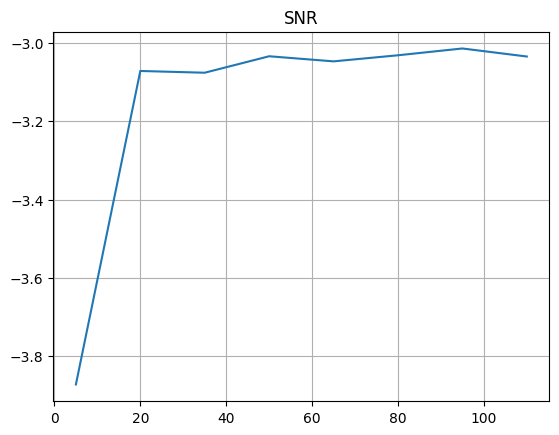

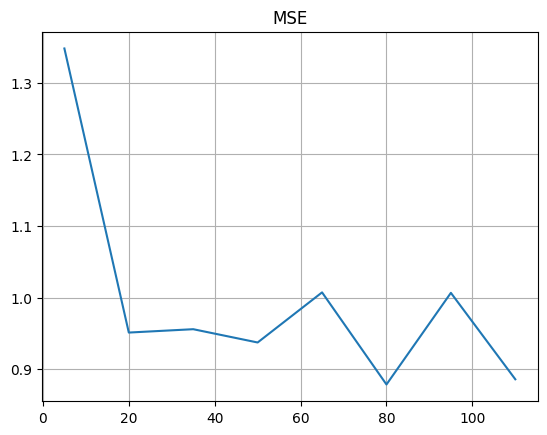

In [9]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA
from scipy.stats import unitary_group
n = 2
sens_arr = np.linspace(5,110,8)
dev = qml.device('default.qubit', wires=n)
L = 2
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
#@qml.qnode(dev)
def VQC(theta,n,L,obs):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



#@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()

def cost(params,n,L):
    VQC(params,n,L,obs)
    qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
    
def Generate_A_y_sens(n,L,sing_range):
    N = 2**n

    U = np.array(unitary_group.rvs(N))
    V = np.array( unitary_group.rvs(N))
    R = min(N,N)
    rands = np.random.rand(R,1)
    sigs = (sing_range[1]-sing_range[0])*rands+sing_range[0]*np.ones((R,1))
    sigs[0] = sing_range[0]
    sigs[1] = sing_range[1]
    A = np.zeros((N,N),dtype = np.complex128)
    for i in range(R):
  
        A += sigs[i]*np.outer(U[i,:],V[i,:])
    
    #A = Generate_Hermitian(N,ver=2,eig_min=eig_range[0],eig_max=eig_range[1])
    y = np.random.rand(N,1)
    y = y/LA.norm(y)
    return A,y
    
    
def Invert_A(A,y,n,L,max_iter=500,step_size=0.03,conv_tol=10e-6):
    dev = qml.device('default.qubit', wires=n)
    VQC2 = qml.QNode(VQC, dev)
    Res2 = qml.QNode(Res, dev)
    #Circuit requires 2n+4nL params or 2n(1+2L) params
    init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

    N = 2**n
    A_inv = LA.inv(A)
    x = np.matmul(A_inv,y)
    
    #prepare the Hamiltonian
    Hd = np.matmul(A.T.conj(),np.eye(N)-np.matmul(y,y.T.conj()))
    Hd = np.matmul(Hd,A)
    Hd =0.5*( Hd+Hd.T.conj())

    obs = qml.Hermitian(Hd, wires=range(n))
    #H = qml.Hamiltonian((0.5,),(obs,))
    opt = qml.GradientDescentOptimizer(step_size)
    new_params = init_params
    cost_arrr = []

    for j in range(max_iter):

        new_params =  opt.step(VQC2, new_params[0],n,L,obs)
        #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
        new_cost = VQC2(new_params[0],n,L,obs)
        cost_arr.append(new_cost)
        
        if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
            break



    v = Res2(new_params[0], n,L)
   
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x
    mse = LA.norm(error)
    SNR = 10*np.log10(LA.norm(x)/mse)
    #u = np.matmul(Hd,np.array([v]).T)
 
    return new_cost,mse,SNR

sig_range = [1,2]
cost_arr = []
mse_arr = []
snr_arr = []
trials = 30
for l in range(len(sens_arr)):
    sig_range[1] = sens_arr[l]
    temp_cost_arr = []
    temp_mse_arr = []
    temp_snr_arr = []
    
    for k in range(trials):
        A,y = Generate_A_y_sens(n,L,sig_range)
        
        cost,mse,SNR = Invert_A(A,y,n,L,max_iter=800)
        temp_cost_arr.append(cost)
        temp_mse_arr.append(mse)
        temp_snr_arr.append(SNR)
        if k%10 == 9:
            print("Iteration: {0}/{1} for k = {2}".format(k+1,trials,LA.cond(A)))

    cost_arr.append(np.mean(temp_cost_arr))
    mse_arr.append(np.mean(temp_mse_arr))
    snr_arr.append(np.mean(temp_snr_arr))
#print(cost_arr)
print(mse_arr)
print(snr_arr)
with open('cost22.npy', 'wb') as f:
    np.save(f, np.array(cost_arr))
with open('snr22.npy', 'wb') as f2:
    np.save(f2, np.array(snr_arr))
with open('mse22.npy', 'wb') as f3:
    np.save(f3, np.array(mse_arr))
plt.figure(1)
plt.plot(sens_arr,snr_arr)
plt.grid()
plt.title('SNR')
plt.figure(2)
plt.plot(sens_arr,mse_arr)
plt.grid()
plt.title('MSE')

Text(0.5, 1.0, 'MSE')

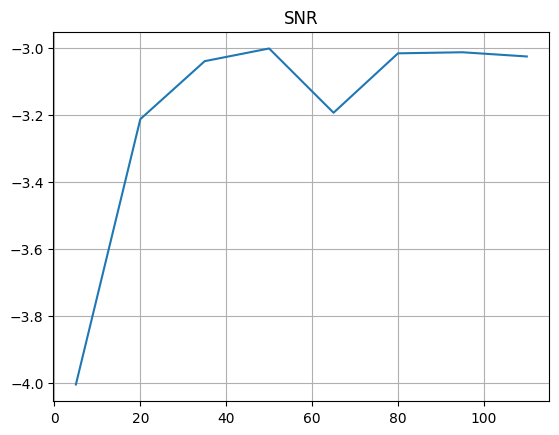

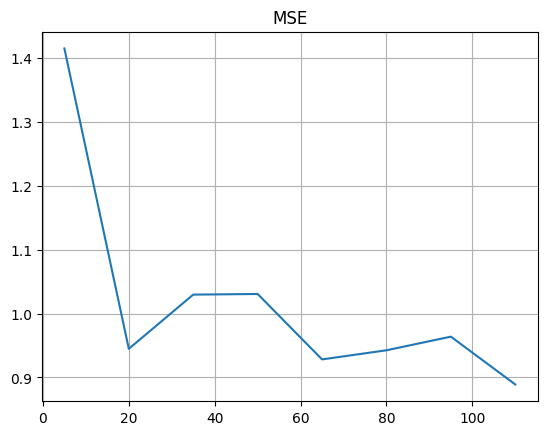

In [6]:

plt.figure(1)
plt.plot(sens_arr,snr_arr)
plt.grid()
plt.title('SNR')
plt.figure(2)
plt.plot(sens_arr,mse_arr)
plt.grid()
plt.title('MSE')

In [3]:
mse_arr1 = mse_arr.copy()
snr_arr1 = snr_arr.copy()
cost_arr1 = cost_arr.copy()


### My Method

In [52]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA
from scipy.stats import unitary_group

# n:dim of x
# m:dim of y
# n*m: dim of A
n = 2
m = 2
dev = qml.device('default.qubit', wires=n+m)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
    #Initial Gates (2n params)
  

    for i in range(n):
        
        W(theta[0][2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[0][2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
    for i in range(m):
        qml.RZ(theta[0][4*n*L+2*n],wires=n+i)
    return qml.state()

def cost(theta,n,L,y):
    v = VQC(theta,n,L)
    w = np.matmul(A,np.array([v]).T)
    z = np.mean(np.divide(y,w))
    x_est = z*v
    error = x_est-x.T

@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[0][2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[0][2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
    for i in range(m):
        qml.RZ(theta[0][4*n*L+2*n],wires=n+i)
    return qml.state()


    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
def Generate_Mtx_SVD(M,N,sing_range = [1,4]):
    U = np.array(unitary_group.rvs(M))
    V = np.array( unitary_group.rvs(N))
    R = min(M,N)
    rands = np.random.rand(N,1)
    sigs = (sing_range[1]-sing_range[0])*rands+sing_range[0]*np.ones((R,1))
    A = np.zeros((M,N),dtype = np.complex128)
    for i in range(R):
  
        A += sigs[i]*np.outer(U[i,:],V[i,:])
    
 
    return A

#Circuit requires 2n+4nL params or 2n(1+2L) params
init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L)+1, 1), requires_grad=True)]

N = 2**n
M = 2**m

A = Generate_Mtx_SVD(M,N)
_, s,_ = np.linalg.svd(A, full_matrices=False)
sens = np.max(np.abs(s))/np.min(np.abs(s))
#print("Eigen Values are: ",w)
#print("Eiegen Vectors:")
#print(v)
print("Sensitivity: ",sens)

#A  = np.array([[3,0,0,0],[0,5,0,0],[0,0,9,0],[0,0,0,2]])
y = np.random.rand(M,1)
y = y/LA.norm(y)

#y = 0.5*np.array([[1],[0],[0],[0]])
A_inv = LA.pinv(A)
x = np.matmul(A_inv,y)



Hd = np.zeros((M+N,M+N),dtype=np.complex128)
Hd[:N,:N] = np.matmul(A.T.conj(),A)
Hd[N:,:N] = -A
Hd[:N,N:] = -A.T.conj()

obs = qml.Hermitian(Hd, wires=range(n+m))
H = qml.Hamiltonian((0.5,),(obs,))

print(qml.draw(VQC)(init_params,n,L))

step_size = 0.03
max_iter = 500
conv_tol = 1e-6
opt = qml.AdamOptimizer(step_size)
new_params = init_params
cost_arr = []



for j in range(max_iter):
    qml.MottonenStatePreparation(state_vector=y[:,0], wires=range(n,n+m))
    new_params =  opt.step(VQC, new_params,n,L)
    #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
    
    new_cost =VQC(new_params,n,L)
    cost_arr.append(new_cost)
    #x.append(y_out[i])
    #y_out.append(serial_quantum_model(weights, x[i+1]))
    if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
        break



print("Gradient Descend converged at {0} steps and cost: {1}".format(j+1,new_cost))  

plt.plot(cost_arr)
plt.grid()
# Ax=y -> v s.t. |v| = 1 and x = z*v, A*v = w, z*w = y, z = <y/w> , x = <y/w>*v


v = Res(new_params, n,L)
w = np.matmul(A,np.array([v]).T)
z = np.mean(np.divide(y,w))
x_est = z*v
error = x_est-x.T
mse = LA.norm(error)
SNR = 10*np.log10(LA.norm(x)/mse)

#print("True x: ",x.T)
#print("Estimated x: ",x_est)
#print("Error: ",error)
print("Mean Square Error: ",mse)
print("Signal to Noise Ratio: ",SNR," dB")

#print(np.divide(v,x.T))
#print(np.divide(w,y))

#print(qml.draw(VQC)(new_params[0], n,L))


Sensitivity:  2.1391565549784826
0: ──RZ(M2)──RY(M4)─╭●──RZ(M6)──RY(M7)─╭X──RZ(M9)───RY(M11)─╭X─╭●─┤ ╭<𝓗(M13)>
1: ──RZ(M0)──RY(M3)─╰X──RZ(M5)──RY(M8)─╰●──RZ(M10)──RY(M12)─╰●─╰X─┤ ├<𝓗(M13)>
2: ──RZ(M1)───────────────────────────────────────────────────────┤ ├<𝓗(M13)>
3: ──RZ(M1)───────────────────────────────────────────────────────┤ ╰<𝓗(M13)>


ValueError: Input unitary must be of shape (16, 16) or (batch_size, 16, 16) to act on 4 wires.

In [14]:
from scipy.stats import unitary_group
from pennylane import numpy as np
def Generate_Mtx_SVD(M,N,sing_range = [1,4]):
    U = np.array(unitary_group.rvs(M))
    V = np.array( unitary_group.rvs(N))
    R = min(M,N)
    rands = np.random.rand(N,1)
    sigs = (sing_range[1]-sing_range[0])*rands+sing_range[0]*np.ones((R,1))
    A = np.zeros((M,N),dtype = np.complex128)
    for i in range(R):
  
        A += sigs[i]*np.outer(U[i,:],V[i,:])
    
 
    return A
print(Generate_Mtx_SVD(5,3))

[[-0.07544507-0.3791463j   1.2223645 +0.5127354j   0.01839098+1.19567892j]
 [ 0.8283162 -0.91121197j  0.13055768-1.36144887j  0.77010715-0.23338778j]
 [-0.27406366+1.64492925j  0.27457203+0.13962632j  0.28850085-1.54312899j]
 [-0.85179055+1.14661638j  0.77345537-2.11465903j -0.11525836+1.05126708j]
 [ 0.80609919+0.38173621j  1.01344803+0.72647185j  1.33448651-0.35418232j]]


In [113]:
n = 2
m = 2
dev = qml.device('default.qubit', wires=n+m)
L = 1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



(0.002607155256999441-2.168404344971009e-19j)


In [124]:
print(np.matmul(A,np.array([out]).T))

[[-0.05663638+0.03548156j]
 [ 0.00672818+0.00290879j]
 [ 0.08075925-0.00687372j]
 [ 0.13479752-0.01091618j]]


In [28]:
v = np.matmul(A,np.array([out]).T)
print(np.divide(v,y))


[[6.589+0.226j]
 [6.589+0.226j]
 [6.589+0.226j]
 [6.589+0.226j]]


In [29]:
z = np.matmul(Hd,np.array([out]).T)
print(z)
print(np.divide(out,x.T))

[[-1.768e-10-6.415e-09j]
 [-9.426e-10-3.214e-09j]
 [-4.183e-11+3.814e-09j]
 [ 1.456e-09+3.115e-09j]]
[[6.589+0.226j 6.589+0.226j 6.589+0.226j 6.589+0.226j]]


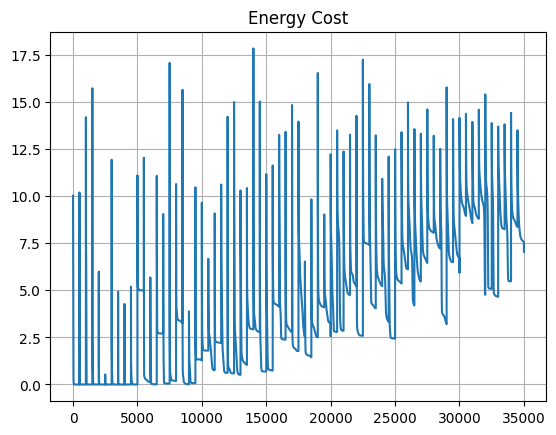

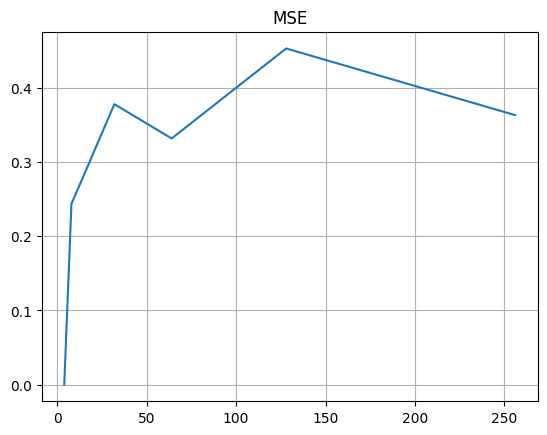

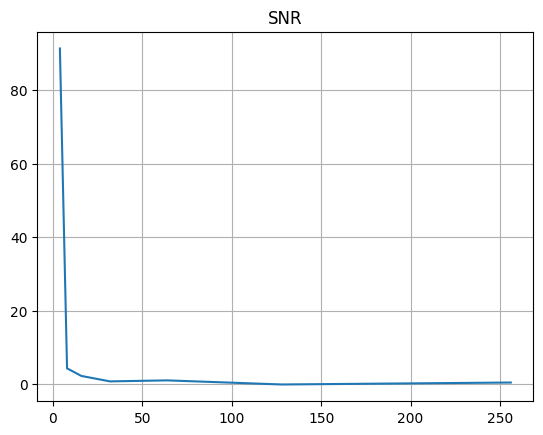

In [15]:
N_arr = []
for n in n_arr:
  N_arr.append(2**n)

plt.figure(1)
plt.plot(np.array(cost_arr))
plt.title("Energy Cost")
plt.grid()
plt.show()

plt.figure(2)
plt.plot(N_arr,np.array(mse_arr))
plt.title("MSE")
plt.grid()
plt.show()

plt.figure(3)
plt.plot(N_arr,np.array(snr_arr))
plt.title("SNR")
plt.grid()
plt.show()

In [43]:

import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg as LA
from scipy.stats import unitary_group

n = 2
dev = qml.device('default.qubit', wires=n)
L =1
np.set_printoptions(precision=3)
#np.random.seed(1543)

def W(theta,wires):
    """Trainable circuit block."""
    qml.RZ(theta[0], wires)
    qml.RY(theta[1], wires)

def Layer(theta,n):
    for i in range(n-1):
        qml.CNOT(wires = [i,i+1])
        W(theta[4*i:4*i+2],i)
        W(theta[4*i+2:4*i+4],i+1)
        
    qml.CNOT(wires = [n-1,0])
    W(theta[4*n-4:4*n-2],n-1)
    W(theta[4*n-2:4*n],0)
        
    
@qml.qnode(dev)
def VQC(theta,n,L):
   
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.expval(obs)



@qml.qnode(dev)
def Res(theta,n,L):
    #Initial Gates (2n params)
    #print(theta)
    for i in range(n):
        
        W(theta[2*i:2*i+2],i)
        
    #Layers    (4n*L params)
    for l in range(L):
        Layer(theta[2*n+4*n*l:4*n*(l+1)+2*n],n)
        
    #Last entengling
    qml.CNOT(wires = [n-1,0])
    
    for i in range(n-1):
        qml.CNOT(wires = [n-i-2,n-i-1]) 
   
    return qml.state()


def cost(params,n,L,A,y):
    v = np.array([Res(params,n,L)])
    #print(np.matmul(A,v.T))
    e = np.matmul(A,v.T)-y
    c = np.vdot(e,e)
    return c
    #qml.expval(H)
    
    
def Generate_Hermitian(N,ver=2,eig_min=2,eig_max=3):
    if ver == 1:
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        A = np.matmul(B,B.T.conj())
        return A
    if ver == 2:
        rands = np.random.rand(N,1)
        eigs = (eig_max-eig_min)*rands+eig_min*np.ones((N,1))
        B = np.random.rand(N,N)
        #random Hermitian Matrix
        C = np.matmul(B,B.T.conj())
        _,v = LA.eig(C)
        A = np.zeros((N,N))
        
        for i in range(N):
            eig_vec = np.array([v[i]])
            A = A+eigs[i]*np.matmul(eig_vec.T.conj(),eig_vec)
            
        return A
    
def Generate_Mtx_SVD(M,N,sing_range = [1,4]):
    U = np.array(unitary_group.rvs(M))
    V = np.array( unitary_group.rvs(N))
    R = min(M,N)
    rands = np.random.rand(R,1)
    sigs = (sing_range[1]-sing_range[0])*rands+sing_range[0]*np.ones((R,1))
    A = np.zeros((M,N),dtype = np.complex128)
    for i in range(R):
  
        A += sigs[i]*np.outer(U[i,:],V[i,:])
    
 
    return A

#Circuit requires 2n+4nL params or 2n(1+2L) params
init_params = [2 * np.pi * np.random.random(size=(2*n*(1+2*L), 1), requires_grad=True)]

N = 2**n
M = 5
A = Generate_Mtx_SVD(M,N)
_, s,_ = np.linalg.svd(A, full_matrices=False)
sens = np.max(np.abs(s))/np.min(np.abs(s))

#print("Eigen Values are: ",w)
#print("Eiegen Vectors:")
#print(v)
print("Sensitivity: ",sens)

#A  = np.array([[3,0,0,0],[0,5,0,0],[0,0,9,0],[0,0,0,2]])
y = np.random.rand(M,1)
y = y/LA.norm(y)
#y = 0.5*np.array([[1],[0],[0],[0]])
A_inv = LA.pinv(A)
x = np.matmul(A_inv,y)

Hd = np.matmul(A.T.conj(),np.eye(M)-np.outer(y,y.T.conj()))
Hd = np.matmul(Hd,A)
Hd =0.5*( Hd+Hd.T.conj())

obs = qml.Hermitian(Hd, wires=range(n))
H = qml.Hamiltonian((0.5,),(obs,))
step_size = 0.03
max_iter = 500
conv_tol = 1e-6
opt = qml.GradientDescentOptimizer(step_size)
new_params = init_params
cost_arr = []

print(cost(new_params[0],n,L,A,y))

for j in range(max_iter):

    new_params =  opt.step(cost, new_params[0],n,L,A,y)
    #new_params =  new_params+mu*error[i]*opt.compute_grad(cost, new_params,[x[i]],[y_out[i]])
    
    new_cost =cost(new_params[0],n,L,A,y)
    cost_arr.append(new_cost)
    #x.append(y_out[i])
    #y_out.append(serial_quantum_model(weights, x[i+1]))
    if (abs((new_cost-cost_arr[j-1])/cost_arr[j-1])<conv_tol)&j>0:
        break



print("Gradient Descend converged at {0} steps and cost: {1}".format(j+1,new_cost))  

plt.plot(cost_arr)
plt.grid()
# Ax=y -> v s.t. |v| = 1 and x = z*v, A*v = w, z*w = y, z = <y/w> , x = <y/w>*v


v = Res(new_params[0], n,L)
w = np.matmul(A,np.array([v]).T)
z = np.mean(np.divide(y,w))
y_est = z*w
error = y-y_est
mse = LA.norm(error)
SNR = 10*np.log10(LA.norm(y)/mse)

#print("True x: ",x.T)
#print("Estimated x: ",x_est)
#print("Error: ",error)
print("Mean Square Error: ",mse)
print("Signal to Noise Ratio: ",SNR," dB")

#print(np.divide(v,x.T))
print(np.divide(w,y))

#print(qml.draw(VQC)(new_params[0], n,L))


Sensitivity:  2.4645790166427632
(11.33358344704003+0j)


NotImplementedError: VJP of vdot wrt argnums (0, 1) not defined